# Table of Contents
 <p><div class="lev1 toc-item"><a href="#greedy" data-toc-modified-id="greedy-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>greedy</a></div><div class="lev1 toc-item"><a href="#epson-greedy" data-toc-modified-id="epson-greedy-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>epson-greedy</a></div><div class="lev1 toc-item"><a href="#optimistic-exploration-greedy" data-toc-modified-id="optimistic-exploration-greedy-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>optimistic exploration greedy</a></div><div class="lev1 toc-item"><a href="#upper-confidence-bound" data-toc-modified-id="upper-confidence-bound-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>upper-confidence bound</a></div><div class="lev1 toc-item"><a href="#gradient" data-toc-modified-id="gradient-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>gradient</a></div><div class="lev1 toc-item"><a href="#All-Together" data-toc-modified-id="All-Together-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>All Together</a></div>

In [667]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [253]:
# 假设老虎机标准差为 1/2 倍均值
# 假设所获得的奖励符合高斯分布
BANDITS = [0.10, -0.20, 1.0, -5.0, 5.0, -20.0, 10.0, 3.0, -2.0, -1.0]
def bandit_reward(bandit):
    # 所有 bandits 的期望
    mu = BANDITS[bandit]
    sigma = np.abs(mu)/2.0
    return np.random.normal(mu, sigma, 10)

In [254]:
# 每次拉老虎机，随机从奖励结果中取一个
def pull_bandit(bandit):
    banditreward = bandit_reward(bandit)
    choose = np.random.randint(0,len(BANDITS)-1)
    return banditreward[choose]

In [255]:
# 验证一下, 可以发现基本能够达到期望值
for i, rew in enumerate(BANDITS):
    result = []
    # 重复 1000 次
    for j in range(1000):
        result.append(pull_bandit(i))
    print("Actual reward: %s; Estimated reward: %s" % (rew, np.average(result)))

Actual reward: 0.1; Estimated reward: 0.09796116798626889
Actual reward: -0.2; Estimated reward: -0.20212861914465624
Actual reward: 1.0; Estimated reward: 1.0073434318381687
Actual reward: -5.0; Estimated reward: -4.944275196351961
Actual reward: 5.0; Estimated reward: 5.044439253974279
Actual reward: -20.0; Estimated reward: -19.83753643354374
Actual reward: 10.0; Estimated reward: 9.93844320243506
Actual reward: 3.0; Estimated reward: 2.9231116309948253
Actual reward: -2.0; Estimated reward: -2.016187174943
Actual reward: -1.0; Estimated reward: -0.9936313263386887


# greedy

In [287]:
# 贪心算法

total_reward = 0
try_reward = []
trial = 3
ite = 0
total_iter = 1000
while ite < total_iter:
    # 各 三次 实验求平均，然后以贪心算法选择最大的 Q
    if ite < trial * len(BANDITS):
        for i in range(len(BANDITS)):
            ite += 1
            reward = round(pull_bandit(i),1)
            try_reward.append(reward)
            total_reward += reward
    else:
        Q_table = np.average(np.array(try_reward).reshape(trial, len(BANDITS)), axis=0)
        # 保留两位小数
        Q_table = list(np.around(Q_table, decimals=1))
        Q = max(Q_table)
        index = Q_table.index(Q)
        ite += 1
        total_reward += Q

assert sum(try_reward) + Q*(total_iter - trial * len(BANDITS)) - total_reward < 1.0
print("获得的总收益：%d，你选择的老虎机期望收益：%s...\n" % (total_reward, BANDITS[index]))
print("你估计的 Q_table: %s, 你选择额的最大 Q: %s, %s 号老虎机。" % (Q_table, Q, index+1))
print("实际中的 Q_table: %s\n" % BANDITS)
if index == BANDITS.index(max(BANDITS)):
    print("You have chosen the best bandit!")
else:
    print("You haven't chosen the best bandit....")

获得的总收益：8047，你选择的老虎机期望收益：5.0...

你估计的 Q_table: [0.1, -0.3, 1.0, -4.0, 8.3, -16.0, 8.2, 3.7, -1.9, -0.2], 你选择额的最大 Q: 8.3, 5 号老虎机。
实际中的 Q_table: [0.1, -0.2, 1.0, -5.0, 5.0, -20.0, 10.0, 3.0, -2.0, -1.0]

You haven't chosen the best bandit....


贪心算法小结：  

注意这个结果是和 bandits 的期望以及标准差相关的。  

- BANDITS 期望一定时：如果标准差很小，那么选择基本会限定在最高的几个老虎机上，如果标准差非常大，则有可能选择到其他的老虎机。
- BANDITS 标准差一定时：期望相差越大，越容易选到最高的几个老虎机上，期望相差越小，则可能选到其他老虎机。

# epson-greedy

In [674]:
# epson-贪心算法1：上来就探索

def epson_greedy(epson):
    total_reward = 0
    is_best = 0
    epson_num = 0
    try_reward = []
    ite = 0
    total_iter = 1000
    Q_table = [0] * len(BANDITS)
    while ite < total_iter:
        if random.random() < epson:
            ite += 1
            epson_num += 1
            choose = np.random.randint(0,len(BANDITS))
            rew = pull_bandit(choose)
            total_reward += rew
            # 更新的值保留两位小数，方便看结果
            Q_table[choose] = round(rew, 2)
            Q = max(Q_table)
            index = Q_table.index(Q)
        # 保留两位小数
        else:
            ite += 1
            Q = max(Q_table)
            index = Q_table.index(Q)
            total_reward += Q        

    print("共探索了 %s 次." % epson_num)
    print("获得的总收益：%d，你选择的老虎机期望收益：%s...\n" % (total_reward, BANDITS[index]))
    print("你估计的 Q_table: %s, 你选择额的最大 Q: %s, %s 号老虎机。" % (Q_table, Q, index+1))
    print("实际中的 Q_table: %s\n" % BANDITS)
    if index == BANDITS.index(max(BANDITS)):
        print("You have chosen the best bandit!")
        is_best = 1
    else:
        print("You haven't chosen the best bandit....")
        is_best = 0
        
    return total_reward, is_best

In [675]:
# epson = 0.1，10% 的概率在探索新的老虎机
epson_greedy(0.1)

共探索了 96 次.
获得的总收益：9815，你选择的老虎机期望收益：10.0...

你估计的 Q_table: [0.11, -0.17, 1.13, -7.44, 5.52, -39.23, 18.85, 3.26, -2.3, -1.1], 你选择额的最大 Q: 18.85, 7 号老虎机。
实际中的 Q_table: [0.1, -0.2, 1.0, -5.0, 5.0, -20.0, 10.0, 3.0, -2.0, -1.0]

You have chosen the best bandit!


(9815.84295988971, 1)

In [735]:
# epson-贪心算法2：先确定一个 Q table 再探索，结合了贪心算法

def epson_greedy2(epson):
    total_reward = 0
    is_best = 0
    epson_num = 0
    try_reward = []
    trial = 3
    ite = 0
    total_iter = 1000
    Q_table = [0] * len(BANDITS)
    while ite < total_iter:
        
        # 先三次实验确定 Q_table，再探索
        if ite < trial * len(BANDITS):
            for i in range(len(BANDITS)):
                ite += 1
                reward = round(pull_bandit(i),1)
                try_reward.append(reward)
                total_reward += reward
        
        else:
            Q_table = np.average(np.array(try_reward).reshape(trial, len(BANDITS)), axis=0)
            Q_table = list(np.around(Q_table, decimals=1))
            # epson 概率选择下一个要拉的老虎机，1-epson 选目前奖励最高的 
            # 如果是非静态的 bandit，可以把 Q_table 中每台 bandit 的 reward 存成 list，然后
            # 用 Q_{n+1} = \sum_{i=1}^n \alpha (1-\alpha)^{n-i} R_i + (1-\alpha)^{n} Q_1 计算即可
            # alpha 为超参数，R_i 为存储的所有 Reward，Q1 为第一次的 Reward
            if random.random() < epson:
                epson_num += 1
                choose = np.random.randint(0,len(BANDITS))
                rew = pull_bandit(choose)
                total_reward += rew
                # 更新的值保留两位小数，方便看结果
                Q_table[choose] = round(rew, 2)
            else:
                ite += 1
                Q = max(Q_table)
                index = Q_table.index(Q)
                total_reward += Q

    print("共探索了 %s 次." % epson_num)
    print("获得的总收益：%d，你选择的老虎机期望收益：%s...\n" % (total_reward, BANDITS[index]))
    # 如果你选的 Q（两位小数）没有在 Q_table，说明最后一次的 Q_table 是 Q_table_new，最大的 Q 是探索出来的
    # 实际中不需要 新建一个 Qtable，这里为了看起来更加直观
    print("你估计的 Q_table: %s, 你选择额的最大 Q: %s, %s 号老虎机。" % (Q_table, Q, index+1))
    print("实际中的 Q_table: %s\n" % BANDITS)
    if index == BANDITS.index(max(BANDITS)):
        print("You have chosen the best bandit!")
        is_best = 1
    else:
        print("You haven't chosen the best bandit....")
        is_best = 0
    return total_reward, is_best

In [737]:
# epson = 0.1，10% 的概率在探索新的老虎机
epson_greedy2(0.1)

共探索了 99 次.
获得的总收益：14300，你选择的老虎机期望收益：10.0...

你估计的 Q_table: [0.1, -0.2, 1.0, -3.8, 3.0, -20.0, 14.9, 4.9, -2.6, -0.9], 你选择额的最大 Q: 14.9, 7 号老虎机。
实际中的 Q_table: [0.1, -0.2, 1.0, -5.0, 5.0, -20.0, 10.0, 3.0, -2.0, -1.0]

You have chosen the best bandit!


(14300.636224221827, 1)

epson-贪心小结：  

- 获得最高的收益时，不一定就是选择了期望收益最大的老虎机。相反也是。当然大部分的情况下，最高的收益对应的是选择了期望最大的老虎机。
- 对 BANDITS 值没有那么敏感。

# optimistic exploration greedy

In [596]:
# optimistic exploration：直到 “失望” 前，一直探索，然后贪心

def opt_greedy(init_q):
    total_reward = 0
    is_best = 0
    epson_num = 0
    try_reward = []
    trial_num = 0
    ite = 0
    total_iter = 1000
    Q_table = [init_q] * len(BANDITS)
    indexes = range(0, len(BANDITS))
    while ite < total_iter: 
        # 当 最大值 是初始乐观值时，一直保持探索（不死心……）
        if max(Q_table) == init_q:
            trial_num += 1
            ite += 1
            choose = indexes[np.random.randint(0, len(indexes))]
            reward = round(pull_bandit(choose), 1)
            total_reward += reward
            
            # 更新 Q table
            Q_table[choose] = round((Q_table[choose] + reward)/2, 1)
            # 更新 indexes
            indexes = [i for i in range(len(Q_table)) if Q_table[i]==init_q]
            
        else:
            ite += 1
            choose = Q_table.index(max(Q_table))
            reward = round(pull_bandit(choose), 1)
            total_reward += reward
            
    print("尝试次数：%s" % trial_num)
    print("获得的总收益：%d，你选择的老虎机期望收益：%s...\n" % (total_reward, BANDITS[choose]))
    print("你估计的 Q_table: %s, 你选择额的最大 Q: %s, %s 号老虎机。" % (Q_table, max(Q_table), choose+1))
    print("实际中的 Q_table: %s\n" % BANDITS)
    if choose == BANDITS.index(max(BANDITS)):
        print("You have chosen the best bandit!")
        is_best = 1
    else:
        print("You haven't chosen the best bandit....")
        is_best = 0
        
    return total_reward, is_best

In [597]:
opt_greedy(10)

尝试次数：10
获得的总收益：10080，你选择的老虎机期望收益：10.0...

你估计的 Q_table: [5.0, 5.0, 5.5, 0.8, 6.3, -7.4, 13.0, 5.2, 3.4, 4.8], 你选择额的最大 Q: 13.0, 7 号老虎机。
实际中的 Q_table: [0.1, -0.2, 1.0, -5.0, 5.0, -20.0, 10.0, 3.0, -2.0, -1.0]

You have chosen the best bandit!


(10080.3, 1)

optimistic exploration 小结：  

- 非常重要：结果与 BANDITS **数据分布**关系极大，当分布方差极大时，很容易收敛到绝对值比较小的期望上。
  - 这点很容易理解，因为方差大（比如 2 倍均值），所以期望大的老虎机总会获得到一个很大的负值 Q，取平均就会导致 Q 变小，结果就再也没有机会选到这台老虎机。
- 相对来说，上面的这种情况在 epson-贪心 和 贪心算法上就会好很多。

# upper-confidence bound

In [633]:
# upper-confidence bound

def ucb(c):
    total_reward = 0
    is_best = 0
    try_reward = []
    ite = 0
    total_iter = 1000
    Q_table_choose = [0] * len(BANDITS)
    Q_table_true = [0] * len(BANDITS)
    N_table = [0] * len(BANDITS)
    while ite < total_iter:
        ite += 1
        # 控制探索次数
        # 也可以用 epson 来控制，epson 满足条件时探索，其他时间贪心
        if ite <= 100:
            choose = np.random.randint(0,len(BANDITS))
            rew = pull_bandit(choose)
            total_reward += rew
            N_table[choose] += 1
            Q_table_choose[choose] = round(rew, 2) + c * np.sqrt(np.log(ite)/N_table[choose])
            Q_table_true[choose] = round(rew, 2)
            index = Q_table_choose.index(max(Q_table_choose))
            Q = Q_table_true[index]
        else:
            total_reward += Q

    print("获得的总收益：%d，你选择的老虎机期望收益：%s...\n" % (total_reward, BANDITS[index]))
    print("你估计的 Q_table: %s, 你选择额的最大 Q: %s, %s 号老虎机。" % (Q_table, Q, index+1))
    print("实际中的 Q_table: %s\n" % BANDITS)
    if index == BANDITS.index(max(BANDITS)):
        print("You have chosen the best bandit!")
        is_best = 1
    else:
        print("You haven't chosen the best bandit....")
        is_best = 0
        
    return total_reward, is_best

In [626]:
ucb(0.1)

获得的总收益：17448，你选择的老虎机期望收益：10.0...

你估计的 Q_table: [0.1, -0.3, 1.0, -4.0, 8.3, -16.0, 8.2, 3.7, -1.9, -0.2], 你选择额的最大 Q: 19.49, 7 号老虎机。
实际中的 Q_table: [0.1, -0.2, 1.0, -5.0, 5.0, -20.0, 10.0, 3.0, -2.0, -1.0]

You have chosen the best bandit!


(17448.197086410153, 1)

# gradient

In [480]:
def softmax(xlist):
    ex = np.exp(xlist - np.max(xlist))
    return ex/np.sum(ex, axis=0)

In [728]:
# gradient
# 不是特别确定理解是否有误
def gradient(alpha):
    is_best = 0
    H_table = np.random.rand(len(BANDITS))
    pi = softmax(H_table)
    ite = 0
    total_iter = 1000
    ht = 0
    total_reward = 0
    while ite < total_iter:
        ite += 1
        # 随机投掷，看 pi 分布下哪个最高就选择哪个
        throw = np.random.multinomial(100, pi)
        choose = list(throw).index(max(throw))
        rew = pull_bandit(choose)
        total_reward += rew
        if rew > 0:
            htnext = ht + alpha * rew * (1 - pi[choose])
        else:
            htnext = ht - alpha * rew * pi[choose]
        H_table[choose] = htnext
        ht = htnext
        pi = softmax(H_table)
    
    print("获得的总收益：%d，你选择的老虎机期望收益：%s...\n" % (total_reward, BANDITS[choose]))
    if list(pi).index(max(pi)) == BANDITS.index(max(BANDITS)):
        print("You have chosen the best bandit!")
        is_best = 1
    else:
        print("You haven't chosen the best bandit....")
        is_best = 0
        
    return total_reward, is_best

In [730]:
gradient(0.1)

获得的总收益：9931，你选择的老虎机期望收益：10.0...

You have chosen the best bandit!


(9931.761125811887, 1)

# All Together

In [ ]:
best_list = []
aver_reward = []
# 重复 100 次实验
N = 100
x = np.logspace(-7, 2, num=10, base=2)

for radio in x:
    ed_best, oeg_best, ucb_best, gra_best = 0, 0, 0, 0
    ed_rew, oeg_rew, ucb_rew, gra_rew = 0, 0, 0, 0
    for i in range(N):
        edr, egb = epson_greedy(radio)
        ed_best += egb
        ed_rew += edr
        oegr, oegb = opt_greedy(radio*100)
        oeg_best += oegb
        oeg_rew += oegr
        ucbr, ucbb = ucb(radio)
        ucb_best += ucbb
        ucb_rew += ucbr
        grar, grab = gradient(radio)
        gra_best += grab
        gra_rew += grar
    best_list.append([ed_best/N, oeg_best/N, ucb_best/N, gra_best/N])
    aver_reward.append([ed_rew/N, oeg_rew/N, ucb_rew/N, gra_rew/N])

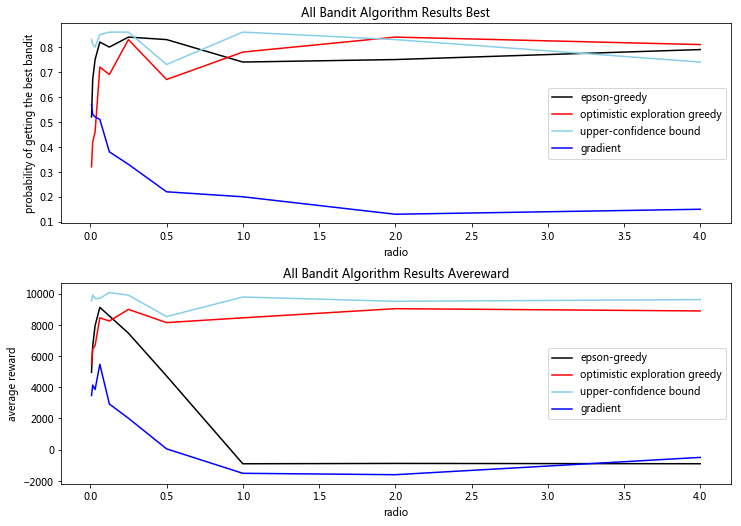

In [732]:
best_list = np.array(best_list)
aver_reward = np.array(aver_reward)
y_edb, y_oegb, y_ucbb, y_grab = best_list[:,0], best_list[:,1], best_list[:,2], best_list[:,3]
y_edr, y_oegr, y_ucbr, y_grar = aver_reward[:,0], aver_reward[:,1], aver_reward[:,2], aver_reward[:,3]

plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=.125, right=.9, bottom=.1, top=.9, wspace=.1, hspace=.3)

plt.subplot(2,1,1)
plt.title('All Bandit Algorithm Results Best')
plt.plot(x, y_edb, color='black', label='epson-greedy')
plt.plot(x, y_oegb, color='red', label='optimistic exploration greedy')
plt.plot(x, y_ucbb,  color='skyblue', label='upper-confidence bound')
plt.plot(x, y_grab, color='blue', label='gradient')
plt.legend()
plt.xlabel('radio')
plt.ylabel('probability of getting the best bandit')

plt.subplot(2,1,2)
plt.title('All Bandit Algorithm Results Avereward')
plt.plot(x, y_edr, color='black', label='epson-greedy')
plt.plot(x, y_oegr, color='red', label='optimistic exploration greedy')
plt.plot(x, y_ucbr,  color='skyblue', label='upper-confidence bound')
plt.plot(x, y_grar, color='blue', label='gradient')
plt.legend()
plt.xlabel('radio')
plt.ylabel('average reward')

plt.show()

和作者的结果不太一样，但大体结果差不多，可能的原因比较多，比如：  

- BANDIT 初始期望设定
- 各算法涉及的其他初始值设定
- 其他代码细节

任意一个原因都可能导致结果大相径庭。但我们的出发点是理解算法思想和流程，大可不必关注太多细节。